In [98]:
# pythonic version of the bash script instructions:
# for link to bash instructions, go to:
# https://gate.nmr.mgh.harvard.edu/wiki/bradmci/index.php/Individual_Reconstruction_%26_Analysis
# https://surfer.nmr.mgh.harvard.edu/fswiki/FsFastTutorialV5.1/FsFastFirstLevel

# note that unpacking takes about 5 min per subject
#           preproc takes about 25 min per subject

import pandas as pd
import re
import os
from os import system
import csv
from datetime import datetime
from paramiko import SSHClient
import os.path
import shutil

In [99]:
homedir = '/autofs/cluster/animal/users/rezzo/Jeanne_Project/' # set directory where "FuncLoc" folder is

# load in subject csv file that is directly downloaded from redcap
projectdir=homedir+'FuncLoc/'
scripts_path=homedir+'scripts/'
paradigmfile = projectdir+'langloc_2cond_slow.par'
subjectdetails = pd.read_csv(projectdir+'PPA_cohort.csv')  ## MUST UPDATE THIS FILE TO MATCH UPDATES IN MASTER_notes.csv (in RECON_REPOSITORY)!
fsaverage_path = '/autofs/cluster/freesurfer/centos7_x86_64/stable6/subjects/fsaverage/'
unpackedtype = 'nii'
sessionlist = []

# if fsaverage is not in folder (make symlink)
if not os.path.islink(projectdir+'fsaverage'):
    os.symlink(fsaverage_path, projectdir+'fsaverage')

In [100]:
def credentials(): # combined with find_dicom
    import getpass
    USER = getpass.getuser()
    print('Please enter your PASSWORD for launchpad access: ')
    PASS= getpass.getpass()
    return USER, PASS

[user,pw] = credentials()

host="launchpad"
client=SSHClient()
client.load_system_host_keys()
client.connect(host,username=user,password=pw, look_for_keys=False)

Please enter your PASSWORD for launchpad access: 
········


In [101]:
def parse_findsession(findsession_output):
    session_values = {}
    for elements in findsession_output:
        try:
            [a, b] = elements.split(": ")
            a = a.strip()
            b = b.strip()
            if a in session_values:
                session_values[a].append(b)
            else:
                session_values[a]=[b]
        except ValueError:
            continue
    for idx, val in enumerate(session_values["DATE"]): #idx in session_values["DATE"]:
        session_values["DATE"][idx] = val.replace(",", "").replace(" ", ", ")
        session_values["DATE"][idx] = str(datetime.strptime(session_values["DATE"][idx], '%B, %d, %Y').date()).replace('-','')
    return session_values

In [102]:
# for each row in dataframe, create a dictionary: "redcapname_date", "reconpath"

for iteration in range(0, subjectdetails.shape[0]):
    # return value of subject_date in this row
    session_date = subjectdetails.loc[iteration, 'scan_date'].replace("/","").replace('-',"")
    session_id = subjectdetails.loc[iteration, 'subject_id']+'_'+session_date
    subj_id = subjectdetails.loc[iteration, 'subject_id']
    print('------BUILDING FS-FAST STRUCTURE FOR '+session_id+' --------------')

    
#     findsession_output = !findsession $subj_id
#     session_values = parse_findsession(findsession_output)
    
#     # return the index of the findsession with the corresponding date
#     for idx, val in enumerate(session_values["DATE"]):
#         if val == session_date:
#             INDX = idx
#     proj = session_values["SUBJECT"][INDX].split("_")[0]
#     taskname = proj+'_'+session_id #session_values["SUBJECT"][INDX] # ## do I need this?
#     srcdir = session_values["PATH"][INDX] #session_values["PATH"][INDX]+"/"
    
    srcdir = subjectdetails.loc[subjectdetails.index[iteration], 'scan_upload_path']
    SESSION_DIR = projectdir+"/"+session_id+'/' #session_values["SUBJECT"][INDX]+'/'
    anatdir = SESSION_DIR+"anat/" 

    sessionlist.append(session_id)
    
    # create anat and dicom dirs
    if not os.path.exists(anatdir):
        os.makedirs(anatdir)
    
    # load in anatomical data (recon symlink)
    try:
        symlink = subjectdetails.loc[iteration, 'recon1_qc_path']
        if symlink == '':
            warn = 'RECON directory is missing. Please add as symlink to subjects ANAT folder later.'
            print(warn)
            system('echo ---------- RECON directory missing. Please add as symlink to ANAT folder -------')
        else:
            try:
                os.symlink(symlink, anatdir+session_id)
                print("Setting up recon in subject directory.")
            except TypeError:
                symlink = ''
                
    except FileExistsError:
        print("Recon is already set-up. Proceeding with unpacking . . . ")
        system('echo ------Recon is already set-up. Proceeding with unpacking------')
        
    # if subjectname file is not setup, set it up
    if os.path.isfile(SESSION_DIR+'subjectname') == False:
        with open(SESSION_DIR+'subjectname', 'w') as f1:
            f1.write(session_id+'/anat/'+session_id + os.linesep)
        
    exists = os.path.isfile(SESSION_DIR+'/scan.info') # checks for scan.info file
    if exists==0:
        # unpack these dicoms
        cmdstring = 'unpacksdcmdir -src %s -targ %s -scanonly %s/scan.info' % (srcdir, SESSION_DIR, SESSION_DIR)
        print(cmdstring)
        system('echo ------unpacking scan info from dicoms-----')
        system(cmdstring)
        
        exists = os.path.isfile(SESSION_DIR+'/scaninfo.csv') # checks for parsed scaninfo.csv file
        if exists==0:
            with open(SESSION_DIR+'/scan.info', 'r') as in_file:
                print("Parsing scan.info to scaninfo.csv ...")
                system('echo -------Parsing scan.info to scaninfo.csv ...-------')
                for line in in_file:
                    # make list out of elements in each line
                    editline = line.split()
                    with open(SESSION_DIR+"/scaninfo.csv", 'a') as result:
                        wr = csv.writer(result, dialect='excel')
                        wr.writerow(editline)
                    result.close()
            in_file.close()
            print("COMPLETED PARSING SCANINFO FILE")
            system('echo ------COMPLETED PARSING SCANINFO FILE------')
        
    # import scan.info from SESSION_DIR as pandas dataframe
    scan_info = pd.read_csv(SESSION_DIR+'/scaninfo.csv', header=None)
    
    # make a bold directory for functional localizer task, and includes all runs within it
    # initialize indexing list to later add to cmdstrng
    run_list = []
    scan_name_index = []
    scan_num_index = []
    runsdir = "bold"
    try:
        os.makedirs(SESSION_DIR+runsdir)
        for row in range(0, len(scan_info.index)):
            if any(ext in scan_info.iloc[row,1] for ext in ['fedorenko', 'fed_lang']):
                print('Currently unpacking functional runs for language task.')
                scan_name_index.append(scan_info.iloc[row,1])
                scan_num_index.append(scan_info.iloc[row,0])
        for name in range(0, len(scan_name_index)):
            temp = ' -run '+ str(scan_num_index[name]) + ' '+ runsdir+ ' ' + unpackedtype + ' ' + 'f.'+unpackedtype
            run_list.append(temp) 

        #combine list of strings into one long string about run info
        runstring = "".join(run_list)
        cmdstring = 'unpacksdcmdir -src %s -targ %s %s' % (srcdir, SESSION_DIR ,runstring) # directory sturture may be messed up!
        print(cmdstring)
        system('echo ------------unpacking raw functional data--------------')
        system(cmdstring)
    except FileExistsError:
        print("functional directory already exists and is unpacked")
        system('echo -------functional directory already exists and is unpacked------')

    #in case no task is found
    if len(os.listdir(SESSION_DIR+runsdir)) == 0:
        os.rmdir(SESSION_DIR+runsdir)
        print("No task "+ runsdir + " findable in scaninfo file. Task probably was not run for this subject.")

    # added recently:     # find each run folder per subject
    runlist = []
    for root, dirs, files in os.walk(projectdir+session_id+'/bold/'):
        for file in files:
            if file.endswith("f.nii"):
                runlist.append(os.path.join(root))
    
    for dst in runlist:
        # go into session_id / bold / each run folder and cp over a .par file
        shutil.copy2(paradigmfile, dst)
    
print("------------------------- UNPACKING COMPLETE --------------------------------")
system('echo ------------------------- UNPACKING COMPLETE --------------------------------')

# create a subject list (all session folder names):

with open(projectdir+'SESSIONLIST', 'w') as in_file:
    for item in sessionlist:
        in_file.write("%s\n" % item)

------BUILDING FS-FAST STRUCTURE FOR DTUB_M_48_20160620 --------------
Recon is already set-up. Proceeding with unpacking . . . 
functional directory already exists and is unpacked
------BUILDING FS-FAST STRUCTURE FOR DTUB_M_48_20170425 --------------
Recon is already set-up. Proceeding with unpacking . . . 
functional directory already exists and is unpacked
------BUILDING FS-FAST STRUCTURE FOR DTUB_M_48_20180606 --------------
Recon is already set-up. Proceeding with unpacking . . . 
functional directory already exists and is unpacked
------BUILDING FS-FAST STRUCTURE FOR DTUB_M_48_20190206 --------------
Recon is already set-up. Proceeding with unpacking . . . 
functional directory already exists and is unpacked
------BUILDING FS-FAST STRUCTURE FOR FCLE_M_27_20130924 --------------
Recon is already set-up. Proceeding with unpacking . . . 
functional directory already exists and is unpacked
------BUILDING FS-FAST STRUCTURE FOR FCLE_M_27_20151009 --------------
Recon is already set-up.

------BUILDING FS-FAST STRUCTURE FOR PDUP_M_35_20140909 --------------
Recon is already set-up. Proceeding with unpacking . . . 
functional directory already exists and is unpacked
------BUILDING FS-FAST STRUCTURE FOR PDUP_M_35_20151026 --------------
functional directory already exists and is unpacked
------BUILDING FS-FAST STRUCTURE FOR PNIC_F_46_20170728 --------------
Recon is already set-up. Proceeding with unpacking . . . 
functional directory already exists and is unpacked
------BUILDING FS-FAST STRUCTURE FOR PNIC_F_46_20181016 --------------
Recon is already set-up. Proceeding with unpacking . . . 
functional directory already exists and is unpacked
------BUILDING FS-FAST STRUCTURE FOR RHUG_M_44_20160113 --------------
functional directory already exists and is unpacked
------BUILDING FS-FAST STRUCTURE FOR RHUG_M_44_20170523 --------------
Recon is already set-up. Proceeding with unpacking . . . 
functional directory already exists and is unpacked
------BUILDING FS-FAST STRUCTU

In [103]:
# copy the .par file into each run directory

for iteration in range(0, subjectdetails.shape[0]):
    session_date = subjectdetails.loc[iteration, 'scan_date'].replace("/","").replace('-',"")
    session_id = subjectdetails.loc[iteration, 'subject_id']+'_'+session_date
        
    runlist = []
    # find each run folder per subject
    for root, dirs, files in os.walk(projectdir+session_id+'/bold/'):
        for file in files:
            if file.endswith("f.nii"):
                runlist.append(os.path.join(root))
    
    for dst in runlist:
        # go into session_id / bold / each run folder and cp over a .par file
        shutil.copy2(paradigmfile, dst)

In [106]:
analysis_cmd = '(cd %s; setenv SUBECTS_DIR %s ; setenv m %s ; %s/run_fsfast.sh)' % (projectdir, projectdir, projectdir, scripts_path)
stdin, stdout, stderr = client.exec_command(analysis_cmd)

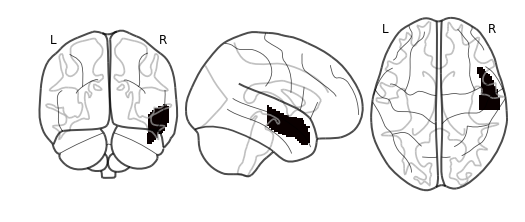

In [174]:
# ANTERIOR TEMPORAL

from nilearn import plotting
from nilearn import image
#IMG_PATH = '/autofs/cluster/animal/users/rezzo/Jeanne_Project/Language_Parcels/Left/FREESURFER_REGISTRATION/LangParcels_n220_LH.nii.gz'
IMG_PATH = '/autofs/cluster/animal/users/rezzo/Jeanne_Project/Language_Parcels/Left_flipped/FREESURFER_REGISTRATION/LangParcels_n220_RH_ROI2.nii.gz'
#display = plotting.plot_stat_m
IMG = nib.load(IMG_PATH)
IMG_data = np.array(IMG.dataobj)

#display = plotting.plot_stat_map(smooth_anat_img)  
display = plotting.plot_glass_brain(IMG_PATH)  
#plotting.plot_img(IMG_PATH)

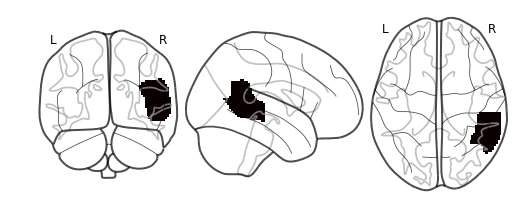

In [173]:
# POSTERIOR TEMPORAL

IMG_PATH = '/autofs/cluster/animal/users/rezzo/Jeanne_Project/Language_Parcels/Left_flipped/FREESURFER_REGISTRATION/LangParcels_n220_RH_ROI1.nii.gz'
display = plotting.plot_glass_brain(IMG_PATH) 

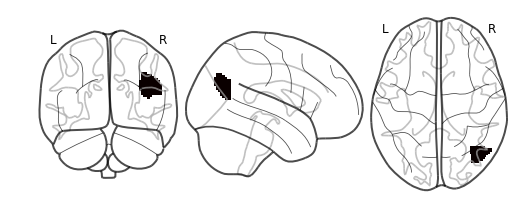

In [175]:
# LEFT ANG Gyrus

IMG_PATH = '/autofs/cluster/animal/users/rezzo/Jeanne_Project/Language_Parcels/Left_flipped/FREESURFER_REGISTRATION/LangParcels_n220_RH_ROI3.nii.gz'
display = plotting.plot_glass_brain(IMG_PATH)

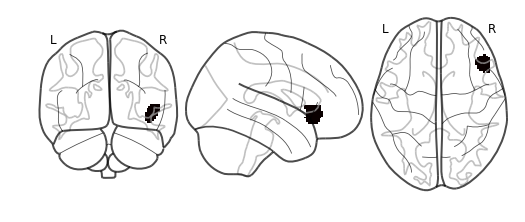

In [176]:
# LEFT INFERIOR FRONTAL GYRUS ORBITAL

IMG_PATH = '/autofs/cluster/animal/users/rezzo/Jeanne_Project/Language_Parcels/Left_flipped/FREESURFER_REGISTRATION/LangParcels_n220_RH_ROI6.nii.gz'
display = plotting.plot_glass_brain(IMG_PATH)

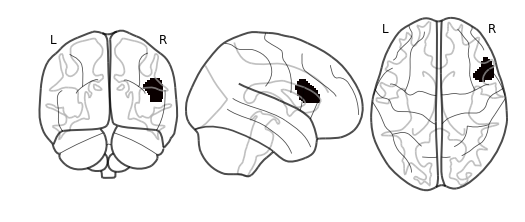

In [177]:
# LEFT INFERIOR FRONTAL GYRUS

IMG_PATH = '/autofs/cluster/animal/users/rezzo/Jeanne_Project/Language_Parcels/Left_flipped/FREESURFER_REGISTRATION/LangParcels_n220_RH_ROI4.nii.gz'
display = plotting.plot_glass_brain(IMG_PATH)

MemoryError: 

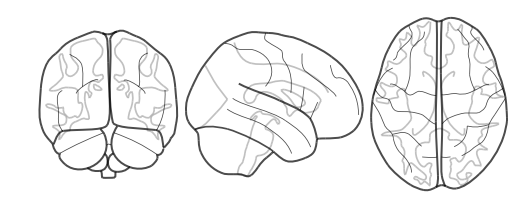

In [186]:
# LEFT MIDDLE FRONTAL GYRUS

IMG_PATH = '/autofs/cluster/animal/users/rezzo/Jeanne_Project/FuncLoc/DTUB_M_48_20160620/bold/langloc_2cond_slow.sm05.lh/word-v-scrambled/t_ANTTEMP_masked.nii.gz'
display = plotting.plot_glass_brain(IMG_PATH)

In [169]:
import numpy as numpy
IMG_data
print(numpy.amax(IMG_data))
print(numpy.amin(IMG_data))

# turn all 4,5,6 into zeros
flattened = IMG_data.flat
uni = numpy.unique(flattened)

6.0
0.0


In [171]:
print(numpy.amax(flattened))
print(numpy.amin(flattened))
print(uni)

6.0
0.0
[0.        0.9999695 1.999939  3.0000916 4.000061  5.0000305 6.       ]


In [179]:
#https://mail.nmr.mgh.harvard.edu/pipermail//freesurfer/2018-February/055778.html
raw_stats = '/autofs/cluster/animal/users/rezzo/RECON_REPOSITORY/DTUB_M_48_20160620/edit.FS6_03/surf/lh.thickness.asc'

In [184]:
# http://www.grahamwideman.com/gw/brain/fs/surfacefileformats.htm
f = open(raw_stats, 'r')
f.read() # I think it is X, Y, Z, thickness value

# but how will I identiy the vertices with the highest t-value?

'000 -9.82340 -88.07764 -35.19197 1.67171\n001 -10.37699 -88.07157 -35.23531 1.55834\n002 -11.37903 -88.31787 -35.52851 1.48542\n003 -11.97050 -88.07109 -35.33632 1.49331\n004 -12.57498 -88.02094 -35.38484 1.55380\n005 -9.85139 -88.17832 -35.55953 1.53487\n006 -10.65031 -88.44180 -35.93298 1.44385\n007 -11.59485 -88.68207 -36.22789 1.51619\n008 -12.24041 -88.47276 -35.75563 1.61348\n009 -13.33824 -88.41473 -35.76667 1.72133\n010 -14.74239 -88.45394 -36.10236 1.64563\n011 -15.92941 -88.26633 -35.95586 1.72650\n012 -16.51356 -88.17088 -35.89569 1.84861\n013 -16.92764 -88.09831 -35.92804 1.92792\n014 -9.90982 -88.28033 -36.51153 1.34750\n015 -10.84145 -88.54773 -37.01514 1.29393\n016 -11.84105 -88.72717 -37.12502 1.40647\n017 -12.58410 -88.82133 -36.53324 1.63345\n018 -13.72123 -88.73242 -36.90519 1.57202\n019 -14.71020 -88.63383 -37.21011 1.43609\n020 -15.65316 -88.52743 -36.97775 1.49108\n021 -16.57962 -88.31548 -36.51132 1.72358\n022 -17.24561 -88.15479 -36.34742 1.86837\n023 -9.98405 

In [185]:
IMG_PATH =  '/autofs/cluster/animal/users/rezzo/Jeanne_Project/FuncLoc/DTUB_M_48_20160620/bold/langloc_2cond_slow.sm05.lh/word-v-scrambled/t.nii.gz'

IMG = nib.load(IMG_PATH)
IMG_data = np.array(IMG.dataobj)

# figure out how to take the top 50 voxels by t-value
print(numpy.amax(IMG_data))
print(numpy.amin(IMG_data))

5.140716
-3.0792243


In [125]:
import nibabel as nib
import numpy as np
t_image = nib.load('/autofs/cluster/animal/users/rezzo/Jeanne_Project/FuncLoc/DTUB_M_48_20160620/bold/langloc_2cond_slow.sm05.lh/word-v-scrambled/t.nii.gz')
t_data = np.array(t_image.dataobj)

PARCEL = nib.load(IMG_PATH)
binary_data = np.array(PARCEL.dataobj)

binary_data[binary_data == 0] = 'nan'
roi_con = t_data*binary_data

MemoryError: 

In [124]:
t_data

array([[[[ 0.5977903 ]]],


       [[[-0.48417214]]],


       [[[ 1.1031291 ]]],


       ...,


       [[[-0.9045303 ]]],


       [[[-0.9735878 ]]],


       [[[-0.98665804]]]], dtype=float32)

In [ ]:
nilearn.masking.apply_mask(imgs, mask_img, dtype='f', smoothing_fwhm=None, ensure_finite=True)